# Final Project: Vehicle Rounting Problem

In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import math
import copy
import random
import timeit

## 1. Import, Data Investigation and Preprocessing

In [34]:
# VRP1
# import distance matrix
filepath = 'VRP1/distance.txt'
with open(filepath, 'r') as t:
    distance_matrix = []
    for line in t.readlines():
        y = [int(value) for value in line.split()]
        distance_matrix.append(y)
        
    t.close()
    distance_matrix = np.array(distance_matrix)

# import demand matrix
filepath = 'VRP1/demand.txt'
with open(filepath, 'r') as t:
    demand_matrix = []
    for line in t.readlines():
        y = [int(value) for value in line.split()]
        demand_matrix.append(y)
        
    t.close()
    demand_matrix = np.array(demand_matrix)
    demand_matrix = demand_matrix[0]
    # since demand matrix has length 100 but the distance_matrix has length 101, we add one demand with 0 to represent the depot 
    demand_matrix = np.insert(demand_matrix,0,0)

# import capacity matrix
filepath = 'VRP1/capacity.txt'
with open(filepath, 'r') as t:
    capacity_matrix = []
    for line in t.readlines():
        y = [int(value) for value in line.split()]
        capacity_matrix.append(y)
        
    t.close()
    capacity_matrix = np.array(capacity_matrix)
    capacity_matrix = capacity_matrix[0]

# import transportation_cost matrix
filepath = 'VRP1/transportation_cost.txt'
with open(filepath, 'r') as t:
    transportation_cost = []
    for line in t.readlines():
        y = [int(value) for value in line.split()]
        transportation_cost.append(y)
        
    t.close()
    transportation_cost = np.array(transportation_cost)
    transportation_cost = transportation_cost[0]

# VRP2

# import distance matrix
filepath = 'VRP2/distance.txt'
with open(filepath, 'r') as t:
    distance_matrix_2 = []
    for line in t.readlines():
        y = [int(value) for value in line.split()]
        distance_matrix_2.append(y)
        
    t.close()
    distance_matrix_2 = np.array(distance_matrix_2)

# import demand matrix
filepath = 'VRP2/demand.txt'
with open(filepath, 'r') as t:
    demand_matrix_2 = []
    for line in t.readlines():
        y = [int(value) for value in line.split()]
        demand_matrix_2.append(y)
        
    t.close()
    demand_matrix_2 = np.array(demand_matrix_2)
    demand_matrix_2 = demand_matrix_2[0]
    # since demand matrix has length 100 but the distance_matrix has length 101, we add one demand with 0 to represent the depot 
    demand_matrix_2 = np.insert(demand_matrix_2,0,0)

    
# import capacity matrix
filepath = 'VRP2/capacity.txt'
with open(filepath, 'r') as t:
    capacity_matrix_2 = []
    for line in t.readlines():
        y = [int(value) for value in line.split()]
        capacity_matrix_2.append(y)
        
    t.close()
    capacity_matrix_2 = np.array(capacity_matrix_2)
    capacity_matrix_2 = capacity_matrix_2[0]
    

    
# import transportation_cost matrix
filepath = 'VRP2/transportation_cost.txt'
with open(filepath, 'r') as t:
    transportation_cost_2 = []
    for line in t.readlines():
        y = [int(value) for value in line.split()]
        transportation_cost_2.append(y)
        
    t.close()
    transportation_cost_2 = np.array(transportation_cost_2)
    transportation_cost_2 = transportation_cost_2[0]

In [11]:
# information about the distance matrix for VRP1
print("Information about distance matric for VRP1 \n# columns: ", len(distance_matrix[0]))
print("# lines: ", len(distance_matrix))
asymmetric = (distance_matrix != np.transpose(distance_matrix))
print(np.unique(asymmetric))
print("Since we also get False values while comparing the matrix with its transposed, the matrix is asymmetric. \n")

# information about the distance matrix for VRP2
print("Information about distance matric for VRP2 \n# columns: ", len(distance_matrix_2[0]))
print("# lines: ", len(distance_matrix_2))
asymmetric_2 = (distance_matrix_2 != np.transpose(distance_matrix_2))
                
print(np.unique(asymmetric_2))
print("Since we also get False values while comparing the matrix with its transposed, the matrix is asymmetric.")

Information about distance matric for VRP1 
# columns:  101
# lines:  101
[False  True]
Since we also get False values while comparing the matrix with its transposed, the matrix is asymmetric. 

Information about distance matric for VRP2 
# columns:  101
# lines:  101
[False  True]
Since we also get False values while comparing the matrix with its transposed, the matrix is asymmetric.


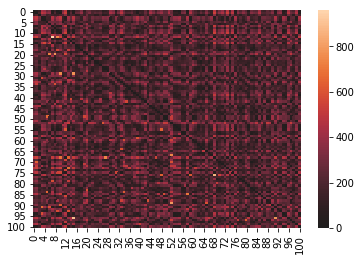

In [12]:
#heatmap
ax = sns.heatmap(distance_matrix, center=0)

The heatmap again illustrates the fact that we have to deal with an asymmetric distance matrix. This property is realistic if we think about. for example, one-way roads. Going from A to B does not strictly have to have the same distance than going from B to A. 

We further notice that we deal with a matrix that does note fulfill the triangle inequality, i.e. the distance from going from A to B has to be always smaller or equal than going from A to B over a third point C. This is not the case in the given distance matrices. This has the consequence that we cannot apply the k-means algorithm since a representation in a cartesian coordinate system is not uniquely possible. 

Our assumption is that the matrix consists of Manhatten distances.

## 2. Heuristic

The initial situation of the Vehicle Routing Problem (VRP) is that we are given a distance matrix, a capacity matrix, a demand matrix and a transportation cost matrix. The aim is to design a route with minimal costs. In order to set up an initial solution, which we then later want to optimize, we deal with the following heuristic: 

1. Take the capacity matrix and randomly pick a car from this list. Remove the entry from the capacity matrix.
2. Start with the customer that is farthest away from the depot and add it to our car. 
3. Keep adding customers to the car, as long as the car still has the capacity to fulfill the customer's demand. Always take the customer that is closest.
4. Stop filling the car when one customer does not fit into the car anymore. Start with 1 again until every customer's demand is fulfilled or we do not have any cars left.  

### 2.1 Helper functions

In [13]:
# find the customer which is closest to another given customer
def find_closest_customer(last_customer_visited, customer_indices,distance_matrix):
    distance_list = []
    for i in customer_indices:
        if i == last_customer_visited:
            # set the distance to customer's own position very high in order for it not the be chosen as the closest customer
            distance_list.append(max(distance_matrix[last_customer_visited]))
        else: 
            distance_list.append(distance_matrix[i][last_customer_visited])
    

    index = distance_list.index(min(distance_list))
    customer_index = customer_indices[index]
    return customer_index      

In [14]:
def total_demand_satisfied(route,demand_matrix):
    total_demand_satisfied = 0
    for i in route:
        total_demand_satisfied += demand_matrix[i]
    return total_demand_satisfied

In [15]:
# randomly pick a car from capacity matrix and return its capacity

def pick_random_car(capacity_matrix):
    car_type = random.randrange(len(capacity_matrix))
    cluster_size = capacity_matrix[car_type]
    return cluster_size

In [16]:
def get_cost_list(cars_used):
    unique_capacity = sorted(set(capacity_matrix)) #VRP1: 100, 300, 500, 1000
    unique_cost = sorted(set(transportation_cost)) #VRP1: 11, 13, 15, 18

    cars_costs = dict(zip(unique_capacity, unique_cost))
    cost_list = [cars_costs.get(value) for value in cars_used]
    return cost_list

### 2.2 Cluster initialization

In [17]:
def cluster_initialization_with_random_cars(demand_matrix,distance_matrix,capacity_matrix):
    clusters = []
    cars_used = []

    customers = copy.deepcopy(demand_matrix)
    capacity = list(copy.deepcopy(capacity_matrix))
    customer_indices = list(range(len(demand_matrix))[1:])

    # keep on creating clusters as long as customers are not satisfied    
    while any(item != 0 for item in customers):
        
        # determine cluster size by randomly pick a car
        cluster_size = pick_random_car(capacity)
        
        # append capacity_size to the list of cars being used
        cars_used.append(cluster_size)
        
        # remove capacity that has been used from the capacity_matrix
        capacity.remove(cluster_size)
        
        if cluster_size not in [100,300,500,1000]:
            car_capacity = capacity_matrix[random.randrange(len(capacity_matrix))]
        else:
            car_capacity = cluster_size

        visited_customers = []

        # keep adding customers as long as capacities are not full
        while car_capacity > 0 and any(item != 0 for item in customers):
            
            # for the starting customer of each car, choose the customer that is farthest away from the depot
            if visited_customers == []:
                max_distance = -1
                max_distance_index = -1
                
                for index in customer_indices:
                    new_distance = distance_matrix[0][index]
                    if new_distance > max_distance:
                        max_distance = new_distance
                        max_distance_index = index
                    
                next_customer = max_distance_index
            # else append everytime the nearest customer
            else:
                last_customer = visited_customers[-1]
                next_customer = find_closest_customer(last_customer,customer_indices,distance_matrix)

            # after choosing next customer only merge if demand is completely covered
            if customers[next_customer] <= car_capacity:
                visited_customers.append(next_customer)
                
                # reduce the capacity by the customer demand
                car_capacity -= customers[next_customer]

                # demand of the customer is fully satsified
                customers[next_customer] = 0
                
                # delete visited customers
                del customer_indices[customer_indices.index(next_customer)]
            else:
                car_capacity = 0

        # create and add this car object to our current solution        
        clusters.append([0]+visited_customers+[0])

    return clusters, cars_used

## 3. Genetic Algorithm

The nature inspired algorithm we use is the genetic algorithm. We want to apply it to our initialized clusters in order to optimize the route of the single cars. To be able to apply the genetic algorithm, we have to create a population (of possible routes a truck could take). Therefore we randomly create permutations of the initialzed clusters. How many permutations of one cluster shall be created, can be set by the parameter population_size.   

In [18]:
# get route and shuffle

def shuffle_cluster(cluster): 
    sliced_cluster = []
    sliced_cluster = cluster[1:len(cluster)-1]
    random.shuffle(sliced_cluster)
    sliced_cluster.append(0)
    sliced_cluster.insert(0,0)    
    return list(sliced_cluster)  

In [19]:
# create as many permutations as given with population_size. It returns a list in which every route is randomly
# shuffled n-times with n being the population size. 

def create_permutations(initialized_clusters, population_size):
    population_list = []
    sliced_shuffled = []
    
    for i in range(len(initialized_clusters)):
        for j in range(population_size):
            sliced_shuffled = shuffle_cluster(initialized_clusters[i])
            if sliced_shuffled not in population_list:
                population_list.append(sliced_shuffled)
            else: 
                unique = False
                while unique == False:
                    sliced_shuffled = shuffle_cluster(initialized_clusters[i])
                    if sliced_shuffled not in population_list:
                        population_list.append(sliced_shuffled)
                        unique = True
                    else: 
                        unique == False

    return population_list

### 3.1 Evaluate Fitness

Here the fitness of one cluster corresponds to the costs. Since we want to minimize our costs, a low evaluation value represents a high fitness. 

In [20]:
# helper function to get the total distance of one single cluster

def total_distance_cluster(cluster):
    total_distance = 0
    
    for i in range(len(cluster)-1):
        total_cluster_distance = total_distance + distance_matrix[cluster[i]][cluster[i+1]]
        total_distance = total_cluster_distance
    return total_distance

In [21]:
# evaluate one single cluster

def evaluate_cluster(transportation_cost,distance_matrix,cluster):
    total_distance = 0
    
    for i in range(len(cluster)-1):
        total_cluster_distance = total_distance + distance_matrix[cluster[i]][cluster[i+1]]
        total_distance = total_cluster_distance
    return transportation_cost * total_distance

In [22]:
# evaluate a list of clusters, i.e. one whole solution

def final_evaluation(list_of_clusters,cost_list):
    total_cost = 0 
    for i in range(len(list_of_clusters)):
        current_cluster = list_of_clusters[i]
        total_cost = total_cost + cost_list[i]*total_distance_cluster(current_cluster)
    return total_cost

### 3.2 Selection

The selection method we use is called tournament selection. It also takes the population (here: population_list), its fitness array and the mating pool size (how many chromosomes do we want to keep) as input. It basically takes the chromosomes that have the lowest cost values. Note that highest fitness level corresponds to lowest cost values in this example since our aim is to minimize the overall costs.

In [23]:
def tournament_selection(population_list, mating_pool_size,population_size,cost_list):
    mating_pool_big = []
    counter = 0
    for i in range(len(population_list)):
        if i % population_size == 0: 
            current_population = population_list[i:i+population_size]
            mating_pool = []
            cost = cost_list[counter]
            counter +=1 
            j = 0
            
            for j in range(mating_pool_size):
                participant1 = current_population[random.randint(0, population_size-1)]
                participant2 = current_population[random.randint(0, population_size-1)]
                
                if (participant1 != participant2):
                    j +=1
                    if evaluate_cluster(cost, distance_matrix, participant1) <= evaluate_cluster(cost, distance_matrix, participant2) :
                        mating_pool = mating_pool + [participant1]
                    else: 
                        mating_pool = mating_pool + [participant2]  
                else: 
                    mating_pool = mating_pool + [participant1] 
                    

            mating_pool_big = mating_pool_big + mating_pool 
    return mating_pool_big

### 3.3 Recombination

 

In recombination, two chromosomes are taken, called parent1 and parent2, and they are recombined (have children, here: child1 and child2) that might produce better outputs, i.e. lower cost.

In uniform_order_based_crossover, we use a template to create valid childs that still visit every customer on the route

In [24]:
def uniform_order_based_crossover(parent1,parent2):
    parent1 = parent1[1:-1]
    parent2 = parent2[1:-1]
    
    table = np.zeros(len(parent1))
    for i in range(len(parent1)):
        table[i]= random.randint(0,1)
    
    child1 = np.zeros(len(parent1))
    child2 = np.zeros(len(parent1))
    for i in range(len(table)):
        if table[i]==1:
            child1[i]=parent1[i]
            child2[i]=parent2[i]
        
    for i in range(len(table)):
        if child1[i]==0:
            for j in range(len(parent2)):
                if parent2[j] not in child1:
                    child1[i] = parent2[j]
                    break
        
        if child2[i]==0:
            for j in range(len(parent1)):
                if parent1[j] not in child2:
                    child2[i] = parent1[j]
                    break
                    
                
    child1 = np.insert(child1,0,0)
    child1 = np.insert(child1, len(child1),0)
    child2 = np.insert(child2,0,0)
    child2 = np.insert(child2, len(child2),0)
                    
    return child1, child2  

In [25]:
def recombine_uniform_order_based_crossover(population_size,mating_pool,crossover_probability, mating_pool_size):
    
    children_clusters_big = []
    
    for i in range(len(mating_pool)):
        if i % mating_pool_size == 0: 
            current_mating_pool = mating_pool[i:i+mating_pool_size]
            children_clusters = [] 

            j = 0
            while j < population_size:
                
                cluster1 = current_mating_pool[random.randint(0,mating_pool_size-1)]
                cluster2 = current_mating_pool[random.randint(0,mating_pool_size-1)]
                
                if cluster2 == cluster1:
                    cluster2 = current_mating_pool[random.randint(0,mating_pool_size-1)]
                    
                if random.random() < crossover_probability:
                    child1, child2 = uniform_order_based_crossover(cluster1,cluster2)
                    child1 = child1.astype(int)
                    child2 = child2.astype(int)
                    child1 = list(child1)
                    child2 = list(child2)
                    children_clusters.append(child1)
                    children_clusters.append(child2)
                    
                    
                    
                else:
                    children_clusters.append(cluster1)
                    children_clusters.append(cluster2)
                
                j+=2
                
            children_clusters_big = children_clusters_big + children_clusters

    return children_clusters_big

### 3.4 Swap Mutation

Mutation (in contrast to recombination) operates locally and tries to improve the fitness level with local optimization techniques. Here we implement the swap mutation, i.e. that given a particular probability, we swap at two randomly chosen locations within the cluster. Mutation makes sense in this example since we deal with an asymmetric matrix. This means that sometimes it is shorter to go from A to B instead from B to A. It is basically a form of permutation, which we have already done in the beginning for a fixed population_size. Nevertheless, we will still consider swap mutation since we will not be able to permutate over all customer nodes of one cluster due to run time. With the help of swap mutation we still might be lucky to consider a better solution.

In [26]:
def swap(cluster,mutation_probability):
    mutated_cluster = np.copy(cluster)
    if random.random() < mutation_probability:
        
        # note that we consider all entries without the first one and the last one since this represents the depot
        location1 = np.random.randint(1,len(cluster)-1)
        location2 = np.random.randint(1,len(cluster)-1)
        
        while location1 == location2:
            location2 = np.random.randint(1,len(cluster)-1)
        help_variable = mutated_cluster[location1]
        mutated_cluster[location1] = mutated_cluster[location2]
        mutated_cluster[location2] = help_variable
        
    return mutated_cluster

In [27]:
def mutate_swap(cluster,mutation_probability):
    all_mutated_clusters = []
    for i in range(len(cluster)):
        mutated_cluster = swap(cluster[i],mutation_probability)
        mutated_cluster = list(mutated_cluster)
        all_mutated_clusters.append(mutated_cluster)
    return all_mutated_clusters

In [28]:
# After last episode, choose best sequence for each cluster. 

def choose_best(all_populations, cost_list,population_size):
    final_clusters = []
    counter = 0
    
    for i in range(len(all_populations)):
        if i % population_size == 0: 
            current_population = all_populations[i:i+population_size]
            cost = cost_list[counter]
            counter += 1
            
            current_best = current_population[0]
            for j in range(population_size):
                if evaluate_cluster(cost, distance_matrix, current_population[j]) < evaluate_cluster(cost, distance_matrix, current_best):
                    current_best = current_population[j]
            final_clusters.append(current_best)
    
    return final_clusters

## 4. Run

In [45]:
# uncomment to choose VRP 2

#demand_matrix = demand_matrix_2
#distance_matrix = distance_matrix_2
#capacity_matrix = capacity_matrix_2
#transportation_cost = transportation_cost_2

In [41]:
# parameter settings for genetic algorithm
population_size = 20
mating_pool_size = 8
crossover_probability = 0.7
mutation_probability = 0.1

# start intializing with out heuristic
starting_best, best_cars = cluster_initialization_with_random_cars(demand_matrix,distance_matrix,capacity_matrix)
best_cost_list = get_cost_list(best_cars)

# create 100 possible solutions with our heuristic and evaluate which one has the best (lowest) initial costs
for i in range(200):

    #start of genetic algorithm
    initialized_clusters, cars_used = cluster_initialization_with_random_cars(demand_matrix,distance_matrix,capacity_matrix)
    cost_list = get_cost_list(cars_used)

    print("Initialized Clusters:")
    print(initialized_clusters, '\n')
    print("Demand satisfied with clusters: ")
    for cluster in initialized_clusters:
        print(total_demand_satisfied(cluster,demand_matrix))
    print('cars used', cars_used)
    print('cost list', cost_list)
    print("cost_before_genetic", final_evaluation(initialized_clusters, cost_list))
    print("starting best", final_evaluation(starting_best, best_cost_list))

    if (final_evaluation(initialized_clusters, cost_list)) < (final_evaluation(starting_best, best_cost_list)): 
        starting_best = initialized_clusters
        best_cost_list = cost_list
        best_cars = cars_used
        

# take the best initial clusters and optimize it with the genetic algorithm
all_populations = create_permutations(starting_best, population_size)
cost_list = best_cost_list
best = all_populations

# store all solutions in one list for plotting
solution_list = []

for i in range(100):

    mating_pool = tournament_selection(all_populations,mating_pool_size,population_size, cost_list)
    new_generation = recombine_uniform_order_based_crossover(population_size,mating_pool,crossover_probability, mating_pool_size)
    mutation = mutate_swap(new_generation, mutation_probability)
    all_populations = mutation
    solution_list.append(final_evaluation(choose_best(all_populations, cost_list,population_size), cost_list))
    print("i", i, final_evaluation(choose_best(all_populations, cost_list,population_size), cost_list))
    if (final_evaluation(choose_best(all_populations, cost_list,population_size), cost_list)) < final_evaluation(choose_best(best, cost_list,population_size), cost_list):
        best = all_populations
            

last_solution = choose_best(all_populations, cost_list,population_size)
final_solution = choose_best(best, cost_list,population_size)

print("last cost:", final_evaluation(last_solution, cost_list),"\n")
print("best cost:", final_evaluation(final_solution, cost_list))
print("car types used: ", best_cars)
print("Final route: ",choose_best(best, cost_list,population_size))

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 72, 5, 33, 84, 79, 90, 37, 40, 19, 0], [0, 75, 71, 93, 68, 88, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 51, 60, 0], [0, 20, 63, 97, 0], [0, 23, 17, 28, 35, 32, 0], [0, 47, 0]] 

Demand satisfied with clusters: 
76
479
75
90
94
72
97
488
84
85
92
91
94
9
cars used [100, 500, 100, 100, 100, 100, 100, 500, 100, 100, 100, 100, 100, 100]
cost list [8, 16, 8, 8, 8, 8, 8, 16, 8, 8, 8, 8, 8, 8]
cost_before_genetic 123864
starting best 119740
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19,

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 40, 37, 75, 25, 63, 20, 45, 55, 94, 99, 81, 0], [0, 80, 0]] 

Demand satisfied with clusters: 
76
296
75
90
94
489
296
499
11
cars used [100, 300, 100, 100, 100, 500, 300, 500, 100]
cost list [8, 12, 8, 8, 8, 16, 12, 16, 8]
cost_before_genetic 125536
starting best 113128
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 77, 2, 62, 

[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 19, 97, 44, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 57, 13, 15, 77, 2, 62, 88, 63, 20, 0], [0, 90, 79, 72, 10, 24, 5, 33, 84, 58, 37, 40, 93, 71, 68, 0]] 

Demand satisfied with clusters: 
76
75
75
285
94
72
498
496
255
cars used [100, 100, 100, 300, 100, 100, 500, 500, 1000]
cost list [8, 8, 8, 12, 8, 8, 16, 16, 19]
cost_before_genetic 124266
starting best 113128
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 1

[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 19, 97, 60, 43, 9, 39, 52, 92, 50, 83, 98, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 71, 93, 40, 37, 4, 20, 0]] 

Demand satisfied with clusters: 
76
75
490
80
487
489
97
132
cars used [100, 100, 500, 100, 500, 500, 100, 1000]
cost list [8, 8, 16, 8, 16, 16, 8, 19]
cost_before_genetic 141806
starting best 112728
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 36, 64, 69, 6, 0], [0, 91, 16, 100, 56, 0], [0, 20, 25, 68, 93, 71, 40, 19, 17, 28, 60, 23, 51, 35, 32, 47, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 37, 97, 0], [0, 18, 0]] 

Demand satisfied with clusters: 
496
75
94
94
279
97
97
96
94
494
10
cars used [500, 100, 100, 100, 300, 100, 100, 100, 100, 500, 1000]
cost list [16, 8, 8, 8, 12, 8, 8, 8, 8, 16, 19]
cost_before_genetic 127522
starting best 112728
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 

97
488
273
182
cars used [100, 500, 100, 100, 100, 100, 100, 500, 300, 300]
cost list [8, 16, 8, 8, 8, 8, 8, 16, 12, 12]
cost_before_genetic 121688
starting best 112160
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 70, 95, 73, 20, 45, 12, 18, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 96, 85, 55, 94, 99, 8, 76, 89, 38, 30, 42, 29, 31, 0], [0, 78, 22, 48, 59, 47, 32, 35, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 37, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 4, 98, 83, 50, 0]] 

Demand satisfied with clusters: 
76
981
295
99
296
97
82
cars used [100, 1000, 300, 100, 300, 100, 300]
cost list [8, 19, 12, 8, 12, 8, 12]
cost_before_genetic 122081
starting best 112160
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 45, 55, 94, 99, 81, 80, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 0], [0, 87, 49, 66, 0], [0, 61, 11, 90, 79, 72, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 93, 71, 68, 0], [0, 20, 40, 37, 58, 10, 24, 5, 33, 84, 0]] 

Demand satisfied with clusters: 
76
75
75
90
984
72
85
278
191
cars used [100, 100, 100, 100, 1000, 100, 100, 300, 300]
cost list [8, 8, 8, 8, 19, 8, 8, 12, 12]
cost_before_genetic 129545
starting best 112160
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 20, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0],

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 37, 58, 5, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 0], [0, 87, 49, 66, 71, 93, 0], [0, 75, 91, 56, 68, 20, 0]] 

Demand satisfied with clusters: 
76
75
75
997
494
99
110
cars used [100, 100, 100, 1000, 500, 100, 300]
cost list [8, 8, 8, 19, 16, 8, 12]
cost_before_genetic 129861
starting best 110880
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 71, 93, 68

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 84, 33, 5, 72, 0], [0, 20, 25, 68, 93, 71, 0], [0, 90, 79, 24, 10, 58, 0], [0, 83, 50, 92, 52, 0], [0, 98, 4, 37, 39, 9, 43, 40, 0]] 

Demand satisfied with clusters: 
1000
296
72
97
94
88
82
85
112
cars used [1000, 300, 100, 100, 100, 100, 100, 100, 300]
cost list [19, 12, 8, 8, 8, 8, 8, 8, 12]
cost_before_genetic 117616
starting best 110880
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 0], [0, 94, 55, 99, 45, 20, 68, 93, 71, 33, 84, 5, 72, 10, 24, 0], [0, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 37, 58, 79, 90, 47, 0]] 

Demand satisfied with clusters: 
76
75
75
90
94
72
296
95
470
297
286
cars used [100, 100, 100, 100, 100, 100, 300, 100, 500, 300, 300]
cost list [8, 8, 8, 8, 8, 8, 12, 8, 16, 12, 12]
cost_before_genetic 119832
starting best 110880
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 25, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 37, 0], [0, 75, 40, 19, 17, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 51, 60, 0], [0, 20, 2, 62, 77, 15, 0], [0, 23, 28, 35, 32, 47, 0], [0, 97, 13, 0]] 

Demand satisfied with clusters: 
291
296
90
94
295
97
284
73
85
92
95
76
58
cars used [300, 300, 100, 100, 300, 100, 300, 100, 100, 100, 100, 100, 100]
cost list [12, 12, 8, 8, 12, 8, 12, 8, 8, 8, 8, 8, 8]
cost_before_genetic 107112
starting best 107904
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 70, 95, 73, 20, 45, 12, 18, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 4

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 36, 64, 69, 6, 0], [0, 94, 55, 99, 45, 0], [0, 91, 16, 100, 56, 0], [0, 81, 80, 23, 17, 0], [0, 20, 63, 88, 0], [0, 83, 50, 92, 52, 39, 9, 43, 40, 19, 28, 97, 44, 57, 13, 53, 21, 62, 2, 77, 15, 82, 25, 68, 93, 71, 37, 4, 98, 0]] 

Demand satisfied with clusters: 
76
75
75
90
290
279
97
96
85
94
87
89
493
cars used [100, 100, 100, 100, 300, 300, 100, 100, 100, 100, 100, 100, 500]
cost list [8, 8, 8, 8, 12, 12, 8, 8, 8, 8, 8, 8, 16]
cost_before_genetic 120344
starting best 107112
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0],

KeyboardInterrupt: 

## 5. Evaluation

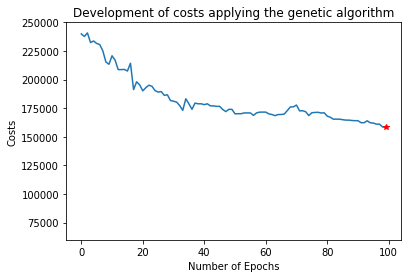

In [44]:
# plot line graph
plt.plot(solution_list)

# get minimum of genetic and set marker
val, idx = min((val, idx) for (idx, val) in enumerate(solution_list))
plt.plot(idx,val,'r*')

# Set limits of y-axis
plt.ylim(bottom=60000,top=250000)

# label axis
plt.xlabel('Number of Epochs')
plt.ylabel('Costs')

# set title
plt.title('Development of costs applying the genetic algorithm')

plt.savefig('pop20_mat8_cross07_mut01_heur150_gen10000.png', dpi=600)

Result of pop20_mat8_cross07_mut01_heur100_gen10000 for Vehicle Routing Problem 1:
- 78236 after initialization
- 75530 after genetic algorithm
- car types used:  [100, 300, 500, 100, 100, 100, 100, 100, 100, 300, 100, 500]
- Final route:  [[0, 25, 11, 68, 12, 73, 3, 99, 51, 4, 59, 29, 44, 75, 33, 85, 30, 92, 65, 90, 34, 80, 5, 93, 77, 0], [0, 13, 55, 58, 9, 94, 53, 81, 54, 31, 40, 95, 43, 24, 23, 74, 63, 45, 48, 96, 71, 79, 21, 83, 17, 98, 16, 35, 91, 0], [0, 8, 61, 86, 67, 41, 28, 22, 88, 49, 50, 60, 42, 97, 72, 84, 47, 57, 82, 70, 18, 6, 32, 56, 89, 0], [0, 15, 10, 7, 76, 87, 37, 14, 20, 52, 38, 19, 100, 39, 1, 0], [0, 26, 27, 78, 69, 46, 0], [0, 64, 36, 66, 2, 62, 0]]
